In [3]:
import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)
import zarr

scikit-allel 1.3.5


SNPs were filtered with (see other notebooks for exploration of this):
- min-mac of 2 (see Battey and Linck, 2019)
- minDP of 200 and max DP of 10k - see Heng Li 2014
- QD > 10 (Ali Miles blog post)
- MQ > 50 (ibid)
- no indels or multiallelics

Import genotypes:

In [4]:
zarr_path = '/Users/dennistpw/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort_filtered.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

Import metadata, and make sure that the metadata and sample callset are in the same order (will output true if so):

In [5]:
df_samples = pd.read_csv('/Users/dennistpw/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv')
samples = callset['samples']
samples_list = list(samples)
samples_callset_index = [samples_list.index(s) for s in df_samples['sample_id']]
df_samples['callset_index'] = samples_callset_index
#df_samples = df_samples.sort_values('callset_index')
df_samples = df_samples.sort_values('callset_index')
np.all(samples[:] == df_samples['sample_id'].values)

True

Prepare GTs for PCA (this is turned into a function below but I have been lazy and left it for the first PCA's for clarity sake:

In [6]:
g = allel.GenotypeChunkedArray(callset['calldata']['GT'])
ac = g.count_alleles()[:]
np.count_nonzero(ac.max_allele() > 1)
#count singletons
np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
#apply filter
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)

In [7]:
#transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we’ll use as the input to PCA.
gn = gf.to_n_alt()

Define color dictionaries of the different sites:

In [8]:
site_colours = {
"Ruakura": "#5A5156",
"Lincoln" : "#E4E1E3",
"Ascasubi" : "#F6222E",
"Bariloche" : "#FE00FA",
"Featherston" : "#16FF32",
"Fortrose" : "#3283FE",
"Hawkes_Bay" : "#FEAF16",
"La_Serena" : "#B00068",
"Mararoa" : "#1CFFCE",
"Mendoza" : "#90AD1C",
"Mossburn" : "#2ED9FF",
"Porto_Alegre" : "#DEA0FD",
"Rio_Negro" : "#AA0DFE",
"Ruakaka" : "#F8A19F",
"Concepcion" : "#325A9B" ,
"Colonia" : "#C4451C",
"Greymouth" : "#1C8356"
}

Define functions for preparing GT data, making PCA figures, and LD pruning data:

In [9]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    #populations = df_samples[sample_population].unique()
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
                label=pop, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title,  sample_metadata, sample_population=None):
    if sample_population is None:
        sample_population = sample_metadata['Species'].values
    else:
        sample_population = sample_metadata[sample_population].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(2, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(2, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax = fig.add_subplot(2, 2, 3)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    ax = fig.add_subplot(2, 2, 4)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    
#prepare gt array for pca - remove singletons,     
def pca_prep(gtarray):
    ac = gtarray.count_alleles()[:]
    np.count_nonzero(ac.max_allele() > 1)
    #count singletons
    np.count_nonzero((ac.max_allele() == 1) & ac.is_singleton(1))
    #apply filter
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gtarray.compress(flt, axis=0)
    #transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we’ll use as the input to PCA.
    gn = gf.to_n_alt()[:]  
    return(gn)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [ ]:
gnu = gn[:]#flatten from array to GT matrix for PCA
#prune gts
gnp = ld_prune(gn, size=5000, step=200, threshold=.1, n_iter=2)
gnp = gnp[:]

In [ ]:
coords_pruned, model_pruned = allel.pca(gnp[:], n_components=10, scaler='patterson')
coords_unpruned, model_unpruned = allel.pca(gnu[:], n_components=10, scaler='patterson')

Plot unpruned GT PCA:

In [ ]:
populations = df_samples.Site.unique()
pop_colours=site_colours
fig_pca(coords_unpruned, model_unpruned, 'Figure 5. Conventional PCA, Site, Unpruned GTs', df_samples, sample_population = 'Site')

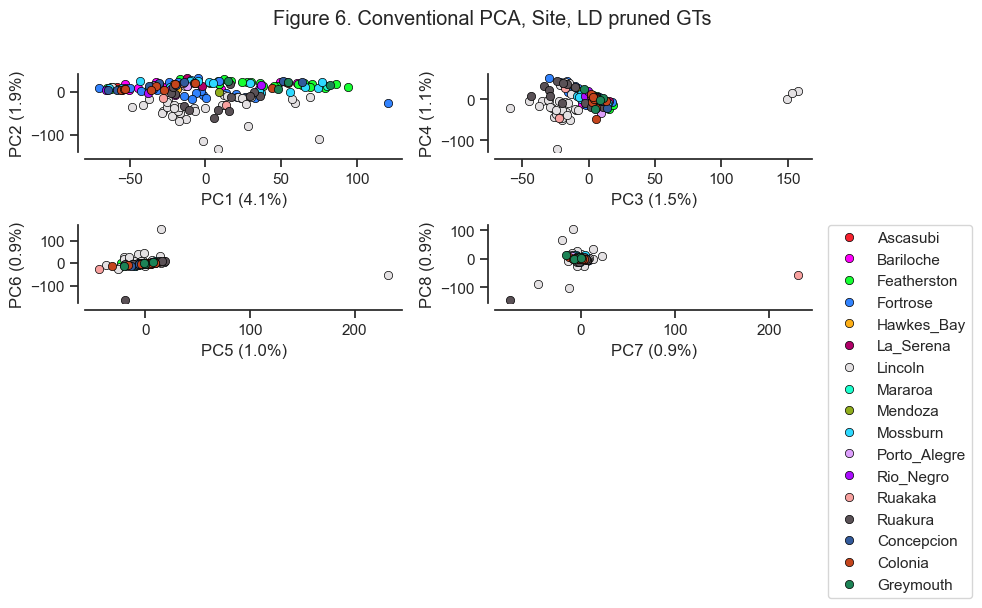

In [372]:
populations = df_samples.Site.unique()
pop_colours=site_colours
fig_pca(coords_pruned, model_pruned, 'Figure 6. Conventional PCA, Site, LD pruned GTs', df_samples, sample_population = 'Site')

You can see lots of weird outliers that don't make any sense. What happens if we plot the LD pruned data?

A lot of the outliers vanish and we get something that looks a lot more sensible - if still unclear. I wonder what effect removing these outliers has, as well as analysing only SA or NZ samples, and removing these outliers has?

In [1]:
pcdf = pd.DataFrame(coords_pruned[:, :2])
pcdf = pd.concat([pcdf, df_samples], axis=1)

NameError: name 'pd' is not defined

Now look specifically at NZ samples PC1 and 2

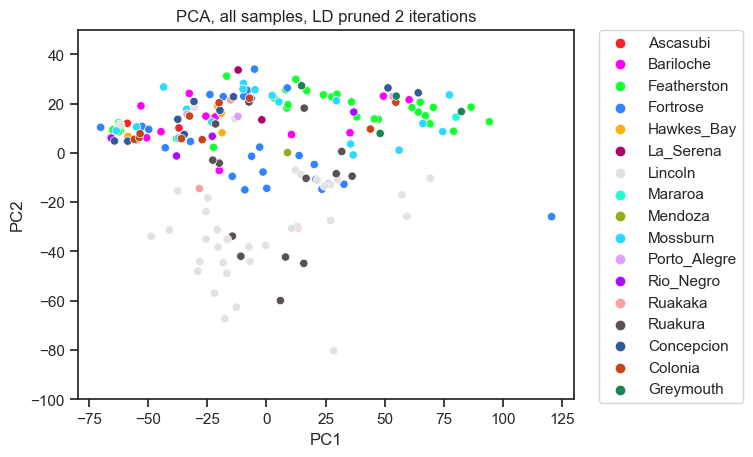

In [379]:
fig = sns.scatterplot(x=pcdf[0], y=pcdf[1], hue=df_samples['Site'], palette=site_colours)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA, all samples, LD pruned 2 iterations") # You can comment this line out if you don't need title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim(-100, 50)
plt.show(fig)

In [2]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sample_population = pcdf['Site'].values
sns.despine(ax=ax, offset=5)
x = pcdf[0]
y = pcdf[1]
#populations = df_samples[sample_population].unique()
for pop in populations:
    flt = (sample_population == pop)
    ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
            label=pop, markersize=6, mec='k', mew=.5)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sample_population = pcdf['Site'].values
sns.despine(ax=ax, offset=5)
x = pcdf[0]
y = pcdf[1]
#populations = df_samples[sample_population].unique()
for pop in populations:
    flt = (sample_population == pop)
    ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], 
            label=pop, markersize=6, mec='k', mew=.5)


NameError: name 'plt' is not defined

In [ ]:
gn_reg = g.take(df_samples[(df_samples['Region']=='South_America')].callset_index.values, axis=1)
gn_reg_meta = df_samples[(df_samples['Region']=='South_America')]
gn_reg_prep = pca_prep(gn_reg)
gn_reg_prep_prun = ld_prune(gn_reg_prep, size=10000, step=200, threshold=.1, n_iter=1)
#run pca
coords_gn_reg_prep_prun, model_gn_reg_prep_prun = allel.pca(gn_reg_prep_prun, n_components=10, scaler='patterson')
sample_population = gn_reg_meta['Site'].values
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 0, 1, ax, sample_population)
ax = fig.add_subplot(1, 2, 2)
plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 2, 3, ax, sample_population)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
fig.suptitle(title, y=1.02)
fig.tight_layout()
fig


fig = sns.scatterplot(x=coords_gn_reg_prep_prun[:,0], y=coords_gn_reg_prep_prun[:,1], hue=gn_reg_meta['Site'], palette=site_colours)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA, all samples, LD pruned 2 iterations") # You can comment this line out if you don't need title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim(-100, 50)
plt.show(fig)

In [ ]:

fig = sns.scatterplot(x=coords_gn_reg_prep_prun[:,0], y=coords_gn_reg_prep_prun[:,1], hue=gn_reg_meta['Site'], palette=site_colours)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA, all samples, LD pruned 2 iterations") # You can comment this line out if you don't need title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim(-100, 50)
plt.show(fig)

In [ ]:
#NZ and SA not removing outliers

iteration 1 retaining 152609 removing 995673 variants
iteration 1 retaining 49812 removing 216784 variants
iteration 1 retaining 152609 removing 995673 variants
iteration 2 retaining 75814 removing 76795 variants
iteration 1 retaining 49812 removing 216784 variants
iteration 2 retaining 36743 removing 13069 variants
iteration 1 retaining 152609 removing 995673 variants
iteration 2 retaining 75814 removing 76795 variants
iteration 3 retaining 52887 removing 22927 variants
iteration 1 retaining 49812 removing 216784 variants
iteration 2 retaining 36743 removing 13069 variants
iteration 3 retaining 35311 removing 1432 variants


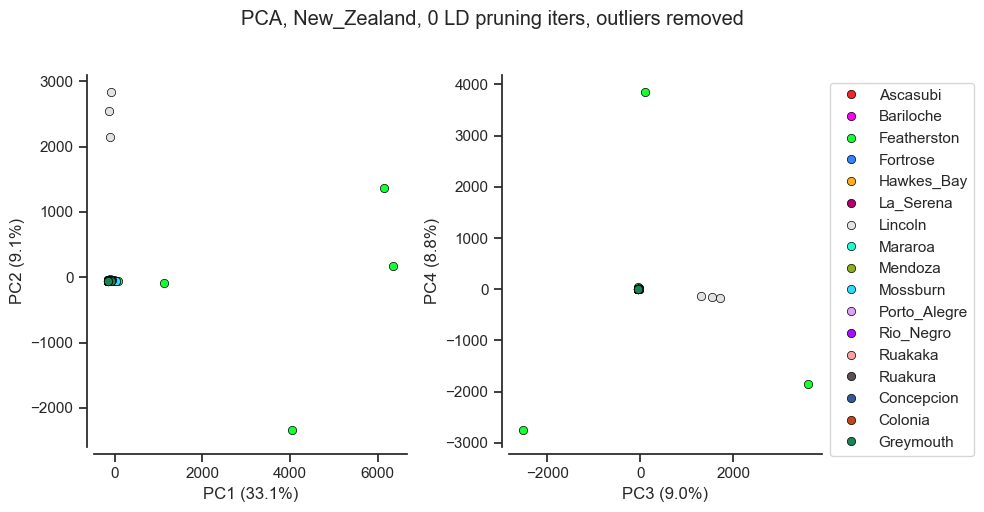

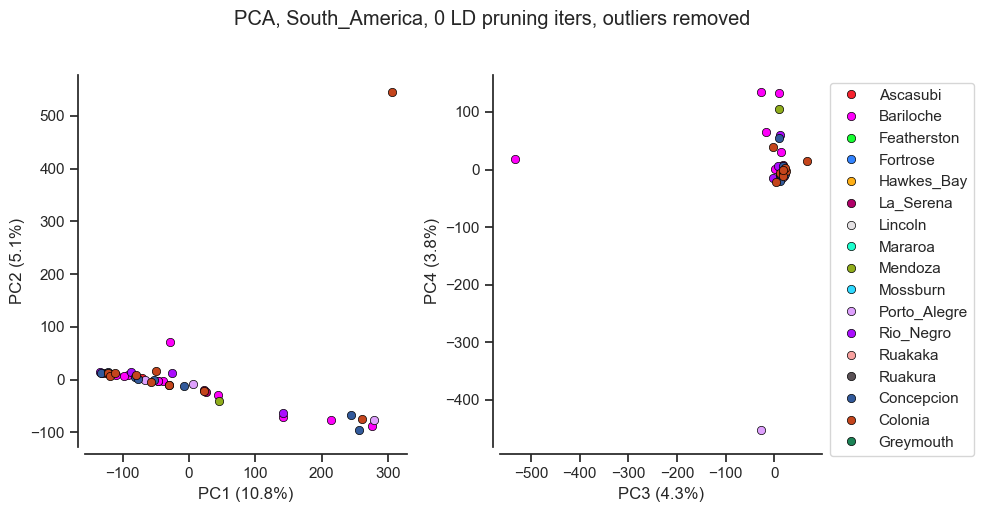

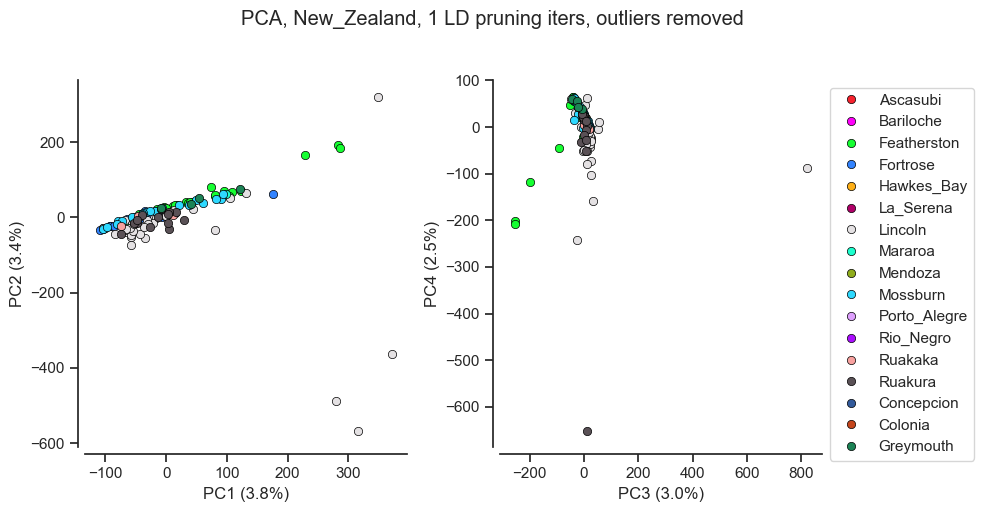

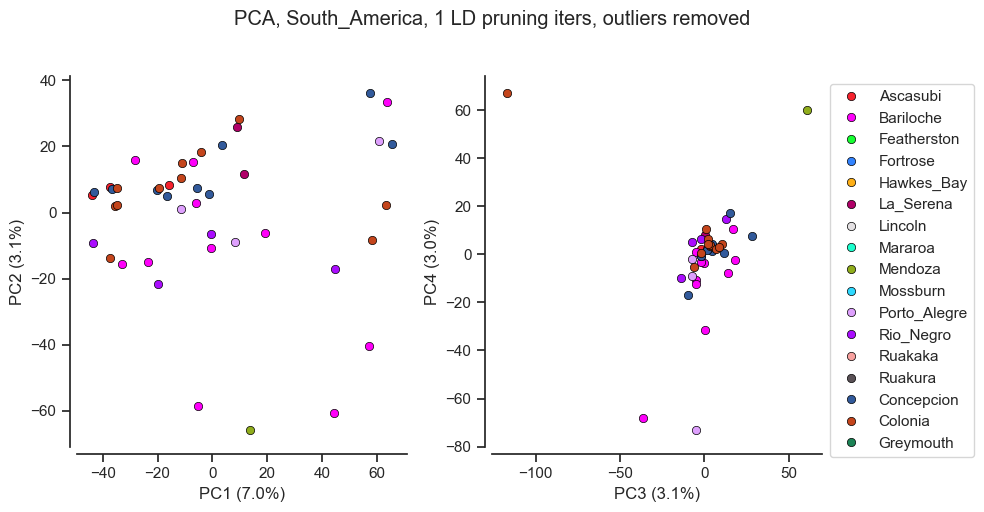

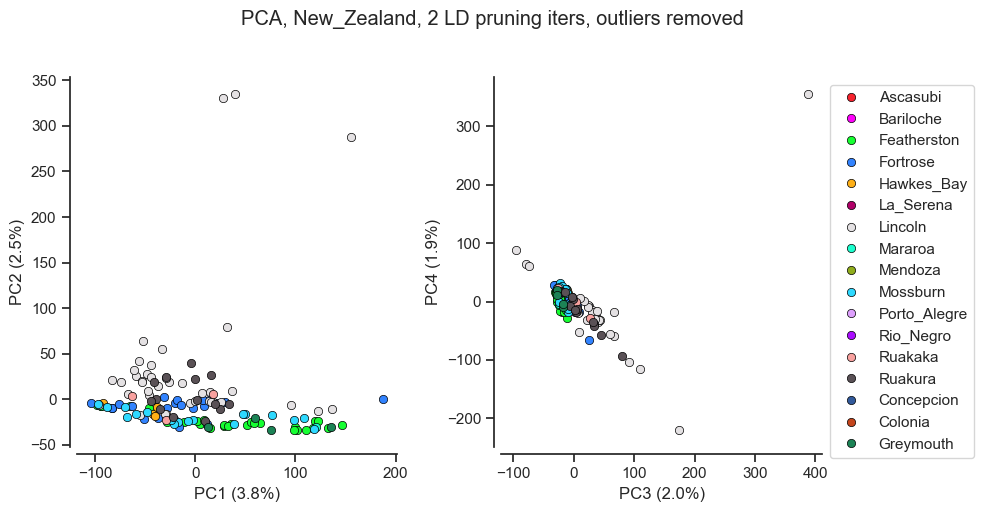

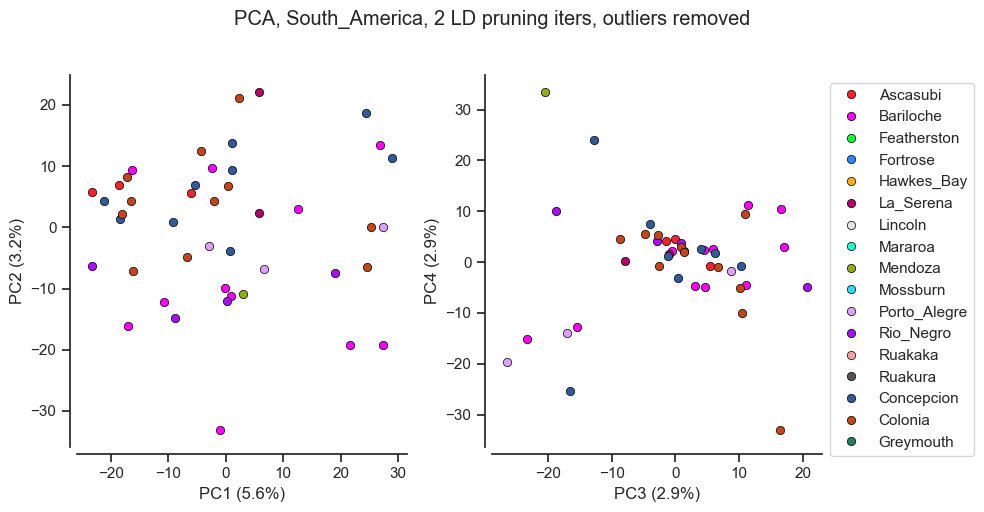

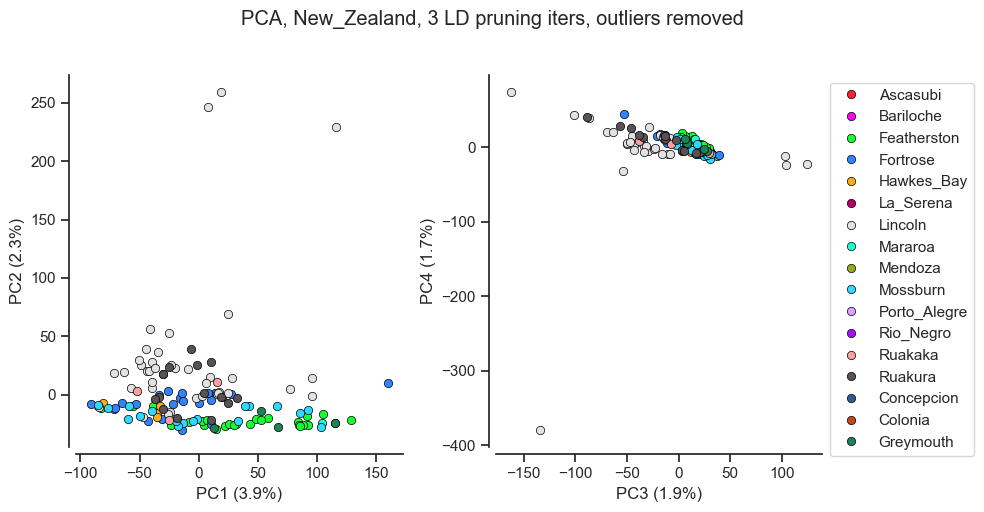

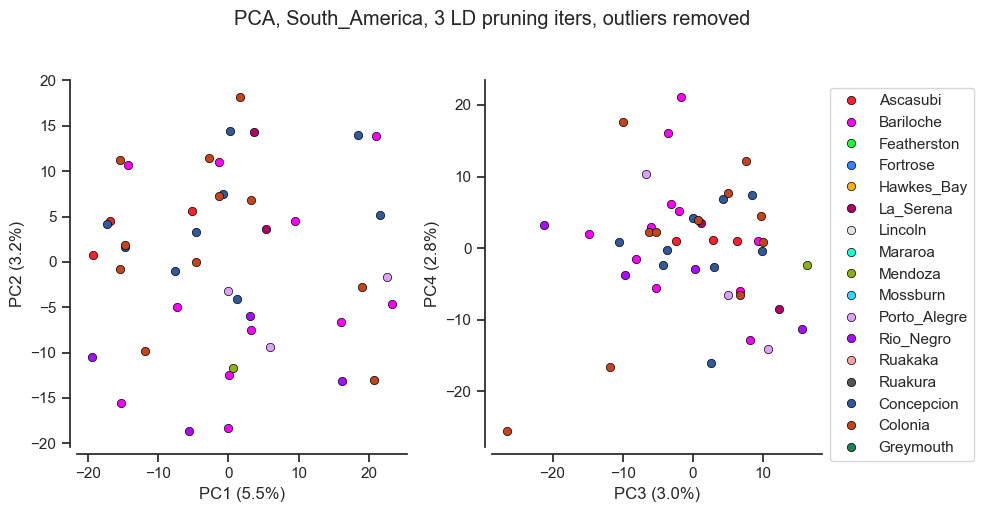

In [380]:
for numiters in 0,1,2,3:
        for region in ['New_Zealand', 'South_America']:
                #get GTs matching conditions
                gn_reg = g.take(df_samples[(df_samples['Region']==region)].callset_index.values, axis=1)
                #subset metadata accordingly
                gn_reg_meta = df_samples[(df_samples['Region']==region)]
                #pre for pca (remove singletons and flatten into 0,1,2 matrix, keep alt alleles only)
                gn_reg_prep = pca_prep(gn_reg)
                #ld prune
                gn_reg_prep_prun = ld_prune(gn_reg_prep, size=500, step=200, threshold=.1, n_iter=numiters)
                #run pca
                coords_gn_reg_prep_prun, model_gn_reg_prep_prun = allel.pca(gn_reg_prep_prun, n_components=10, scaler='patterson')
                #plot title
                title = f'PCA, {region}, {numiters} LD pruning iters, outliers removed'
                #define sample populations
                sample_population = gn_reg_meta['Site'].values
                # plot coords for PCs 1 vs 2, 3 vs 4
                fig = plt.figure(figsize=(10, 5))
                ax = fig.add_subplot(1, 2, 1)
                plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 0, 1, ax, sample_population)
                ax = fig.add_subplot(1, 2, 2)
                plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 2, 3, ax, sample_population)
                ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
                fig.suptitle(title, y=1.02)
                fig.tight_layout()
                fig

In [ ]:
for numiters in 0,1,2,3,4:
    #get GTs matching conditions
    gn_reg = g
    #subset metadata accordingly
    gn_reg_meta = df_samples
    #pre for pca (remove singletons and flatten into 0,1,2 matrix, keep alt alleles only)
    gn_reg_prep = pca_prep(gn_reg)
    #ld prune
    gn_reg_prep_prun = ld_prune(gn_reg_prep, size=500, step=200, threshold=.1, n_iter=numiters)
    #run pca
    coords_gn_reg_prep_prun, model_gn_reg_prep_prun = allel.pca(gn_reg_prep_prun, n_components=10, scaler='patterson')
    #plot title
    title = f'PCA, all samples, {numiters} LD pruning iters, outliers kept'
    #define sample populations
    sample_population = gn_reg_meta['Site'].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords_gn_reg_prep_prun, model_gn_reg_prep_prun, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    fig

### Some observations
Removing the 'outgroups' from the initial PCA really does nothing when you LD prune in parallel. Perhaps the weird outliers are an artefact of some kind of linkage effect. LD pruning generally gives you greater signal until you prune with 3 iterations, at which point you have so few snps (few 1000s) that it doesn't matter all that much and it looks like we begin to lose signal, unless for the full cohort of samples.

The South American samples generally group according to their location on either side of the Andes. Group Oeste you have samples from Concepcion and La Serena, and from Group Este you have those from Mendoza, Bariloche and Ascasubi, and there's some weak signal of a Colonia, Rio Negro and Porto Alegre (subgroup Norte) subgroup within Este. Subgroup Norte is only really visible in the single iteration of LD pruning PCA, and in further iterations, the samples jump all over the plot in ways that don't make much sense (perhaps pruning removes too many SNPs and they lose informativeness, or maybe inversion polymorphism causes this weird pattern that is removed when pruned).

The NZ samples are a bit all over the place too - understandably, as a hotchpotch of lineages were released but broadly we see some clustering by geography - with a lot of mixing overall, however.

When consdiered together, the samples do group weakly according to Oeste/Este - Oeste contains Ruakura (some) and single samples from Mossburn and Ruakuka. Oeste is contained within the remaining samples. In our sample set, the samples predominantly seem to be more closely related to the samples from group  Este vs Oeste - does this mean samples from Este are generally more successful for some reason?

### Some questions
1. Do other analyses give us a clearer picture of population structuring and origin group dominance?
    - Can we sequence more from the native range?
    - Can we sequence some from the intermediate time points?
    - ADMIXTURE/STRUCTURE, mtDNA phylogenies, DAPC, AMOVA
    
2. Why does LD pruning have such an effect on PCA output?
    - Inversion polymorphisms or areas of reduced recomb?
    - Fsts?
    - PCA/STRUCTURE by chromosome?
    - He/Ho over the chromosomes?
3. Where are the gaps in our sequencing that will help us see whether Grupo Este is truly the dominant group?


Final figs - all sample PCA

SA PCA:

In [ ]:
gn_reg = g.take(df_samples[(df_samples['Region']=='South_America')].callset_index.values, axis=1)

In [ ]:
sagt_pca = pca_prep(gn_reg)
gnu = sagt_pca[:]#flatten from array to GT matrix for PCA
#prune gts
gnu = ld_prune(gnu, size=500, step=200, threshold=.1, n_iter=2)
coords_pruned, model_pruned = allel.pca(gnu[:], n_components=10, scaler='patterson')

In [ ]:
newpcdf = df_samples[(df_samples['Region']=='South_America')]

In [ ]:
fig = sns.scatterplot(x=coords_pruned[:,0], y=coords_pruned[:,1], hue=newpcdf['Site'],palette=site_colours)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA, all samples, LD pruned 1 iterations") # You can comment this line out if you don't need title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show(fig)

In [ ]:
newpcdf